### Prepare env

In [1]:
!pip install torchinfo

### Imports

In [26]:
import os
import numpy as np
from tqdm import tqdm
from torchinfo import summary
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision.transforms import transforms, ToTensor

### Set device

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Database preprocessing for binary classification

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])

train_dataset = FashionMNIST(root='./', train=True, download=True, transform=transform)
test_dataset =  FashionMNIST(root='./', train=False, download=True, transform=transform)

# Rebalancing dataset -> 18k shoes + 7 other classes x 2571 ~= 18k
shoes, other = [], []

for idx, element in enumerate(train_dataset):
    if element[1] == 5 or element[1] == 7 or element[1] == 9:
        shoes.append(idx)
    else:
        other.append(idx)

shoes_data = [train_dataset[x] for x in shoes]

items_dict = train_dataset.class_to_idx
clothes = []
for item in items_dict:
    if items_dict[item] != 5 and items_dict[item] != 7 != 9:
        x = [train_dataset[x] for x in other if train_dataset[x][1] == items_dict[item]][:2571] #2571 examples from each class of non shoe category.
        clothes.extend(x)

relabeled_shoe_data = []
for data in shoes_data:
    new_data = list(data)
    new_data[1] = 1.0
    relabeled_shoe_data.append(new_data)

relabeled_clothes_data = []
for data in clothes:
    new_data = list(data)
    new_data[1] = 0.0
    relabeled_clothes_data.append(new_data)

train_set = relabeled_shoe_data + relabeled_clothes_data

# Test data
relabeled_test_data = []
for data in test_dataset:
  if data[1] == 5 or data[1] == 7 or data[1] == 9:
    new_data = list(data)
    new_data[1] = 1.0
    relabeled_test_data.append(new_data)
  else:
    new_data = list(data)
    new_data[1] = 0.0
    relabeled_test_data.append(new_data)

### Database split

In [5]:
# Creating Datasets
SPLIT_RATIO = 0.8
BATCH_SIZE = 128

train_size = int(len(train_set)*SPLIT_RATIO)
val_size = int(len(train_set) - train_size)



train, validation = random_split(dataset = train_set,
                          lengths = [train_size, val_size],
                          generator = torch.Generator().manual_seed(77))

train_dataloader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(dataset=validation, batch_size=BATCH_SIZE, shuffle = False, num_workers=2)
test_dataloader = DataLoader(dataset=relabeled_test_data, batch_size=BATCH_SIZE, shuffle = False, num_workers=2)

### Testing training dataset and assigned label correnctness

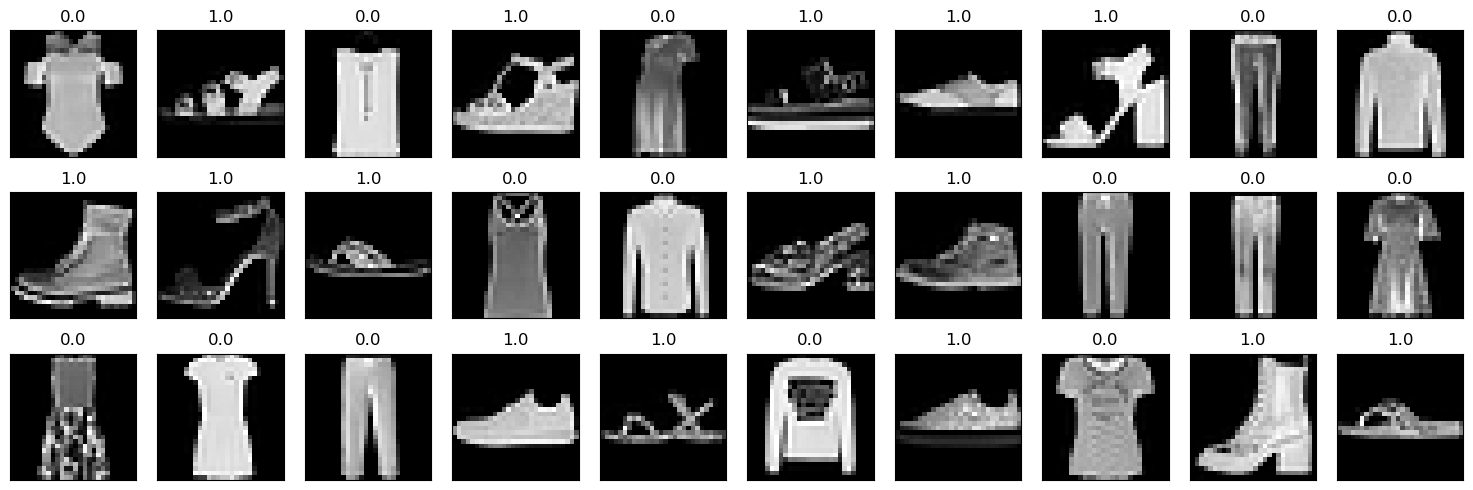

In [6]:
# Just checking train/val label correctness
dataiter = iter(train_dataloader)
print(dataiter)
images, labels = next(dataiter)

fig = plt.figure(figsize=(15,5))
for idx in np.arange(30):
  ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(labels[idx].item())
  fig.tight_layout()

### Same as above, just for a testing data

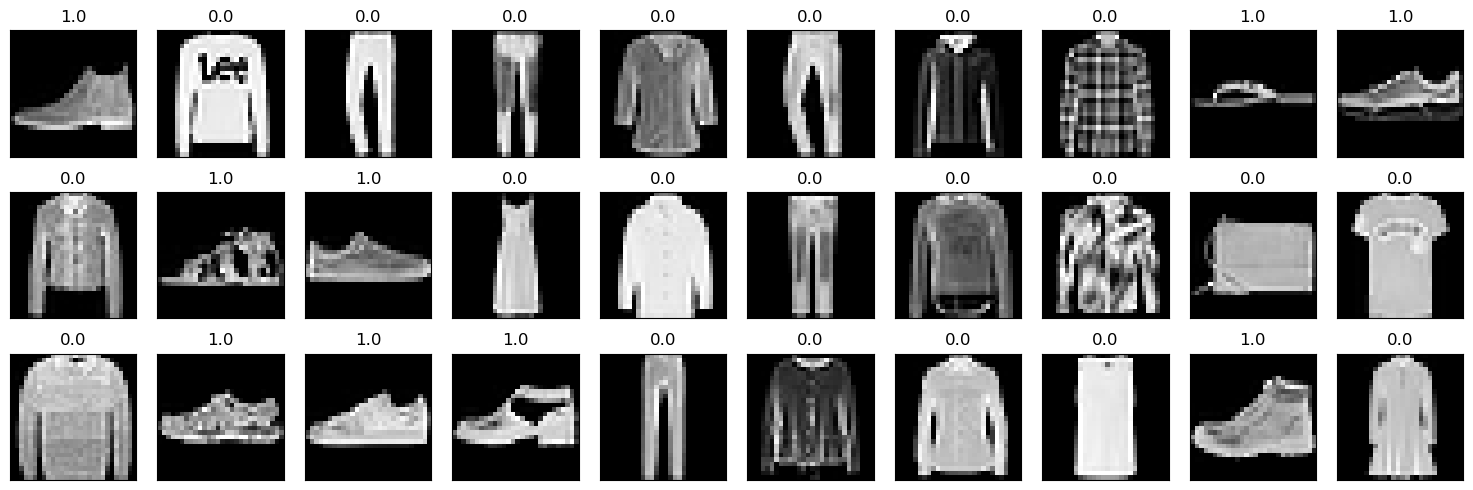

In [7]:
# Just checking test label correctness
dataiter = iter(test_dataloader)
print(dataiter)
images, labels = next(dataiter)

fig = plt.figure(figsize=(15,5))
for idx in np.arange(30):
  ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(labels[idx].item())
  fig.tight_layout()

### Accuracy function

In [8]:
# Accuracy function
def calculate_accuracy(outputs, labels):
    predictions = torch.round(torch.sigmoid(outputs))
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

### Neural Net model class

In [11]:
class BinaryFMnist(nn.Module):
    def __init__(self):
        super(BinaryFMnist, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.relu = nn.LeakyReLU()
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.linear2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=1)

    def forward(self, x):
        # conv 1
        x = self.conv1(x)
        x = self.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # conv 2
        x = self.conv2(x)
        x = self.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # fc1
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        # fc2
        x = self.linear2(x)
        x = self.relu(x)
        # output
        x = self.out(x)

        return x

### Training and validation

In [12]:
EPOCHS = 100
LEARNNING_RATE = 0.00001

model = BinaryFMnist().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNNING_RATE)

# Train & validate
epoch_loss, val_epoch_loss, val_epoch_accuracy = [], [], []

for epoch in range(EPOCHS):
    running_loss = 0.0

    #Train
    for img, label in tqdm(train_dataloader, leave=True, desc=f'Epoch:{epoch+1}/{EPOCHS}'):
        img, label = img.to(device), label.to(device)
        output = model(img)
        output = output.squeeze()
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss.append(running_loss)

    #Validate
    model.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        val_running_accuracy = 0.0

        for v_img, v_label in val_dataloader:
            v_img, v_label = v_img.to(device), v_label.to(device)
            output = model(v_img)
            output = output.squeeze()
            val_loss = criterion(output, v_label)
            val_running_loss += val_loss.item()

            val_accuracy = calculate_accuracy(output, v_label)
            val_running_accuracy += val_accuracy

        val_epoch_loss.append(val_running_loss)
        val_epoch_accuracy.append(val_running_accuracy / len(val_dataloader))

Epoch:100/100: 100%|██████████| 225/225 [00:03<00:00, 69.72it/s]


### Train & validation loss plot

Training loss:  10.471139366164957
Validation loss:  2.394598818943984
Validation accuracy:  98.9487390350877


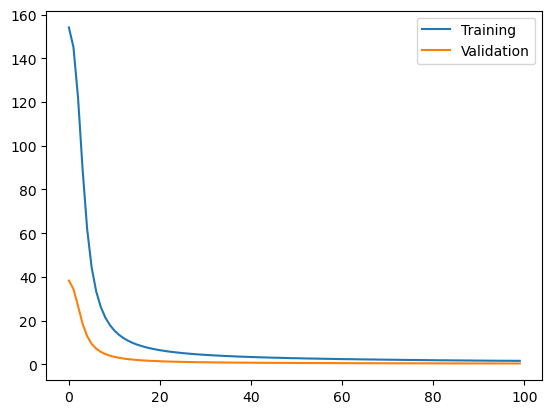

In [14]:
print("Training loss: ", sum(epoch_loss)/len(epoch_loss))
print("Validation loss: ", sum(val_epoch_loss)/len(val_epoch_loss))
print("Validation accuracy: ", sum(val_epoch_accuracy)*100/len(val_epoch_accuracy))

fig, ax = plt.subplots()
ax.plot(epoch_loss, label='Training')
ax.plot(val_epoch_loss, label='Validation')
leg = ax.legend();

### Testing

In [15]:
# TEST
test_loss = 0.0
test_accuracy = 0.0
model.eval()

with torch.no_grad():
    for t_img, t_label in test_dataloader:
        t_img, t_label = t_img.to(device), t_label.to(device)
        output = model(t_img)
        output = output.squeeze()
        test_loss += criterion(output, t_label).item()  # Convert labels to Long data type
        test_accuracy += calculate_accuracy(output, t_label)

test_loss /= len(test_dataloader)
test_accuracy /= len(test_dataloader)

print('Testing Loss:', test_loss)
print(f'Testing Accuracy: {test_accuracy * 100}%')

Testing Loss: 0.008561266098616897
Testing Accuracy: 99.78243670886076%


In [16]:
torch.save(model.state_dict(), './model.pth')

### Transfer Learning 

In [21]:
class BinaryFMnist(nn.Module):
    def __init__(self):
        super(BinaryFMnist, self).__init__()
       # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.relu = nn.LeakyReLU()
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.linear2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=1)

    # define forward function
    def forward(self, x):
        # conv 1
        x = self.conv1(x)
        x = self.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # conv 2
        x = self.conv2(x)
        x = self.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # fc1
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        # fc2
        x = self.linear2(x)
        x = self.relu(x)
        # output
        x = self.out(x)

        return x


In [22]:
model = BinaryFMnist()
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [23]:
print(summary(model, input_size=(128, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
BinaryFMnist                             [128, 1]                  --
├─Conv2d: 1-1                            [128, 6, 24, 24]          156
├─LeakyReLU: 1-2                         [128, 6, 24, 24]          --
├─Conv2d: 1-3                            [128, 12, 8, 8]           1,812
├─LeakyReLU: 1-4                         [128, 12, 8, 8]           --
├─Flatten: 1-5                           [128, 192]                --
├─Linear: 1-6                            [128, 120]                23,160
├─LeakyReLU: 1-7                         [128, 120]                --
├─Linear: 1-8                            [128, 60]                 7,260
├─LeakyReLU: 1-9                         [128, 60]                 --
├─Linear: 1-10                           [128, 1]                  61
Total params: 32,449
Trainable params: 32,449
Non-trainable params: 0
Total mult-adds (M): 30.25
Input size (MB): 0.40
Forward/backward pass siz

### Freezeing layers and replacing with a two new one to learn new weights

In [27]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

#Replace 2 last FC layers
model.linear1 = nn.Linear(192, 120)
model.linear2 = nn.Linear(120, 60)
model.out = nn.Linear(60, 1)

### Loading training examples - one for each category 

In [28]:
flats_train = torchvision.io.read_image('./heels_flats/train/Flats/107.png')
heels_train = torchvision.io.read_image('./heels_flats/train/Heels/746.png')
img = [flats_train, heels_train]

transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                transforms.Normalize((0.5,), (0.5,))])

images = [transform(x) for x in img]
label_flats, label_heels = torch.tensor(1.0), torch.tensor(0.0)
labels = [label_flats, label_heels]

class ShoeDataset(Dataset):
    def __init__(self, imgs, label):
        self.image = imgs
        self.label = label

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        label = self.label[idx]
        return image, label

train_dataset = ShoeDataset(images, labels)
transfer_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

### Loading testing examples

In [30]:
flats_test = [torchvision.io.read_image(os.path.join('./heels_flats/test/Flats', img_dir)) for img_dir in os.listdir('./heels_flats/test/Flats')]
heels_test = [torchvision.io.read_image(os.path.join('./heels_flats/test/Heels', img_dir)) for img_dir in os.listdir('./heels_flats/test/Heels')]

transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                transforms.Normalize((0.5,), (0.5,))])

flats_images = [transform(x) for x in flats_test]
heels_images = [transform(x) for x in heels_test]

flats_labels = [torch.tensor(1.0) for x in range(len(flats_images))]
heels_labels = [torch.tensor(0.0) for x in range(len(heels_images))]

images = flats_images + heels_images
labels = flats_labels + heels_labels

class TestShoeDataset(Dataset):
    def __init__(self, imgs, label):
        self.image = imgs
        self.label = label

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        label = self.label[idx]
        return image, label

test_dataset = TestShoeDataset(images, labels)
transfer_test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Retrainging new layers for new objective

Epoch:49/50: 100%|██████████| 2/2 [00:00<00:00, 350.78it/s]


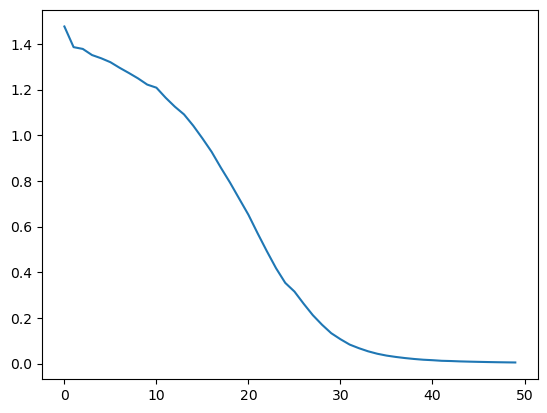

In [31]:
EPOCHS = 50
LEARNNING_RATE = 0.001
# m c o
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNNING_RATE)

#TRAIN
epoch_loss = []
for epoch in range(EPOCHS):
    running_loss = 0.0
    for img, label in tqdm(transfer_dataloader, leave=True, desc=f'Epoch:{epoch}/{EPOCHS}'):
        img, label = img.to(device), label.to(device)

        output = model(img)
        output = output[0]

        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss.append(running_loss)

plt.plot(epoch_loss)

In [32]:
# TEST
test_loss = 0.0
test_accuracy = 0.0
model.eval()
with torch.no_grad():
    for t_img, t_label in transfer_test_dataloader:
        t_img, t_label = t_img.to(device), t_label.to(device)
        output = model(t_img)
        output = output[0]
        test_loss += criterion(output, t_label).item()  # Convert labels to Long data type
        test_accuracy += calculate_accuracy(output, t_label)

test_loss /= len(transfer_test_dataloader)
test_accuracy /= len(transfer_test_dataloader)

print('Testing Loss:', test_loss)
print(f'Testing Accuracy: {test_accuracy * 100}%')

Testing Loss: 0.29165171732893214
Testing Accuracy: 85.0%
